## Bankruptcy Prediction

# Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import plot_roc_curve, auc, precision_score, accuracy_score, recall_score
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_roc_curve, auc, precision_score, accuracy_score, recall_score
from sklearn import tree


In [5]:
# import and show the basic structure of the dataset
df = pd.read_csv("data.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [6]:
df.shape

(6819, 96)

Our dataset contains 6819 rows and 96 columns.

In [7]:
# check the missing values
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

No missing values.

In [8]:
# check the duplicates
df.duplicated().sum()

0

Text(0.5, 1.0, 'Bankrupt?')

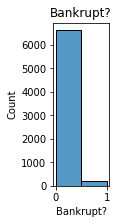

In [9]:
# plotting Bankrupt? column

# define figure size
plt.figure(figsize=(1, 3))

# histogram
sns.histplot(df['Bankrupt?'], bins=2);
plt.title('Bankrupt?')

The dataset is imbalanced. We need to use an oversampling rechnique or undersampling technique to deal with it.

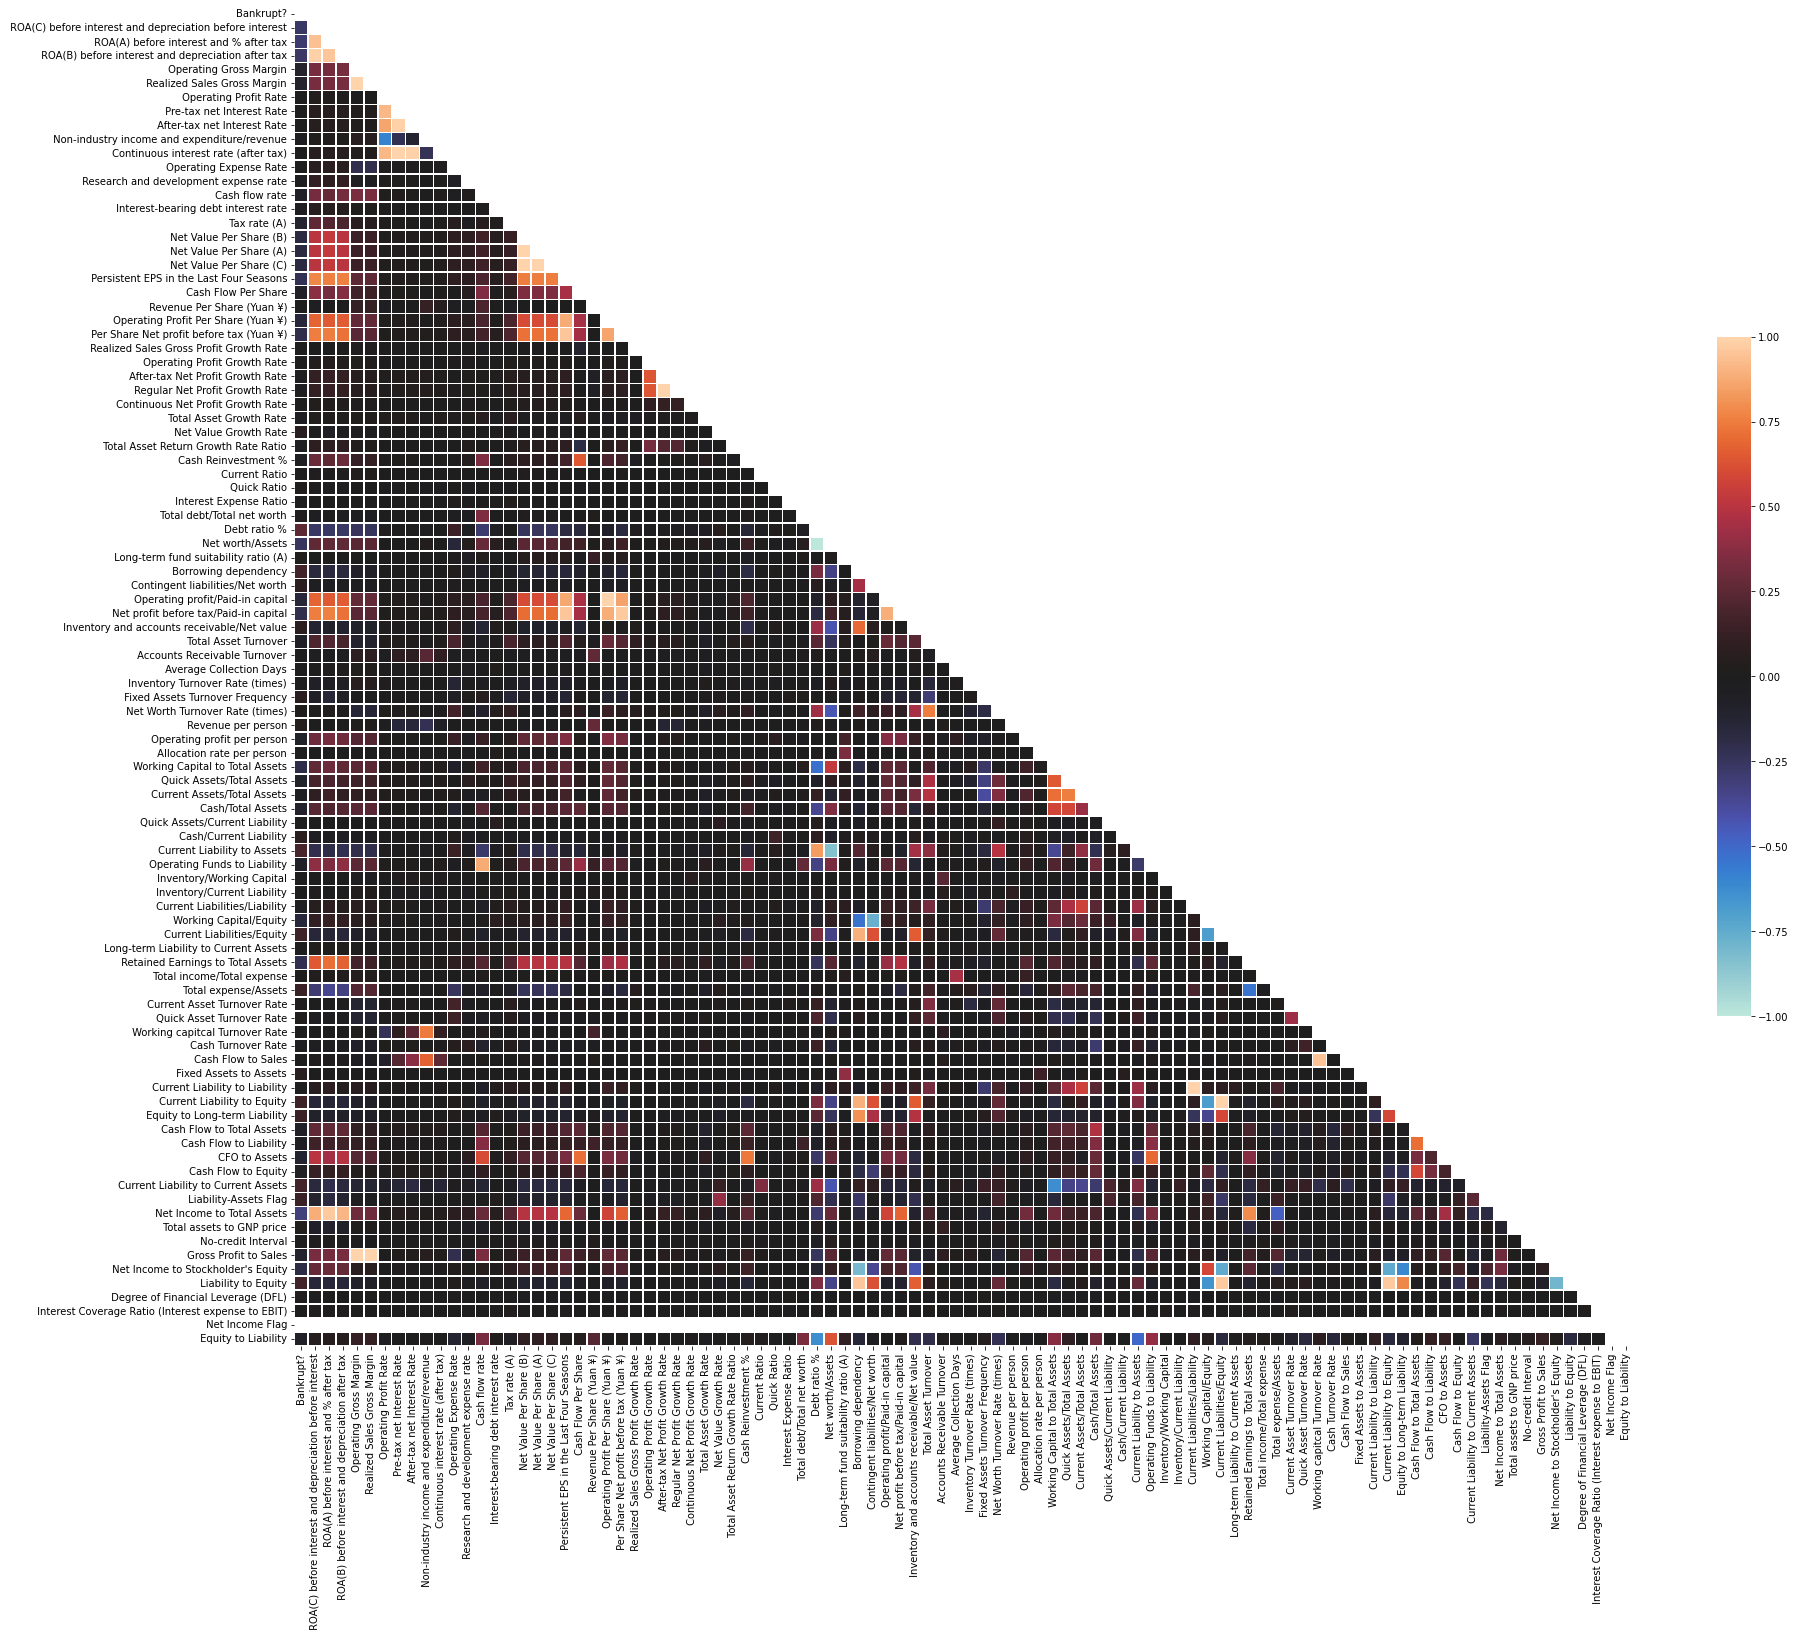

In [10]:
fig, ax = plt.subplots(figsize=(30, 25))

mat = df.corr()

mask = np.triu(np.ones_like(mat, dtype=bool))

sns.heatmap(data=mat, mask=mask,
            ax=ax, #annot=True, 
            center=0, vmax=1, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# We drop Net Income Flag since it looks unrelated to bankruptcy in the graph
df.drop(columns=[' Net Income Flag'], axis=1, inplace=True)

**Removing outliers**

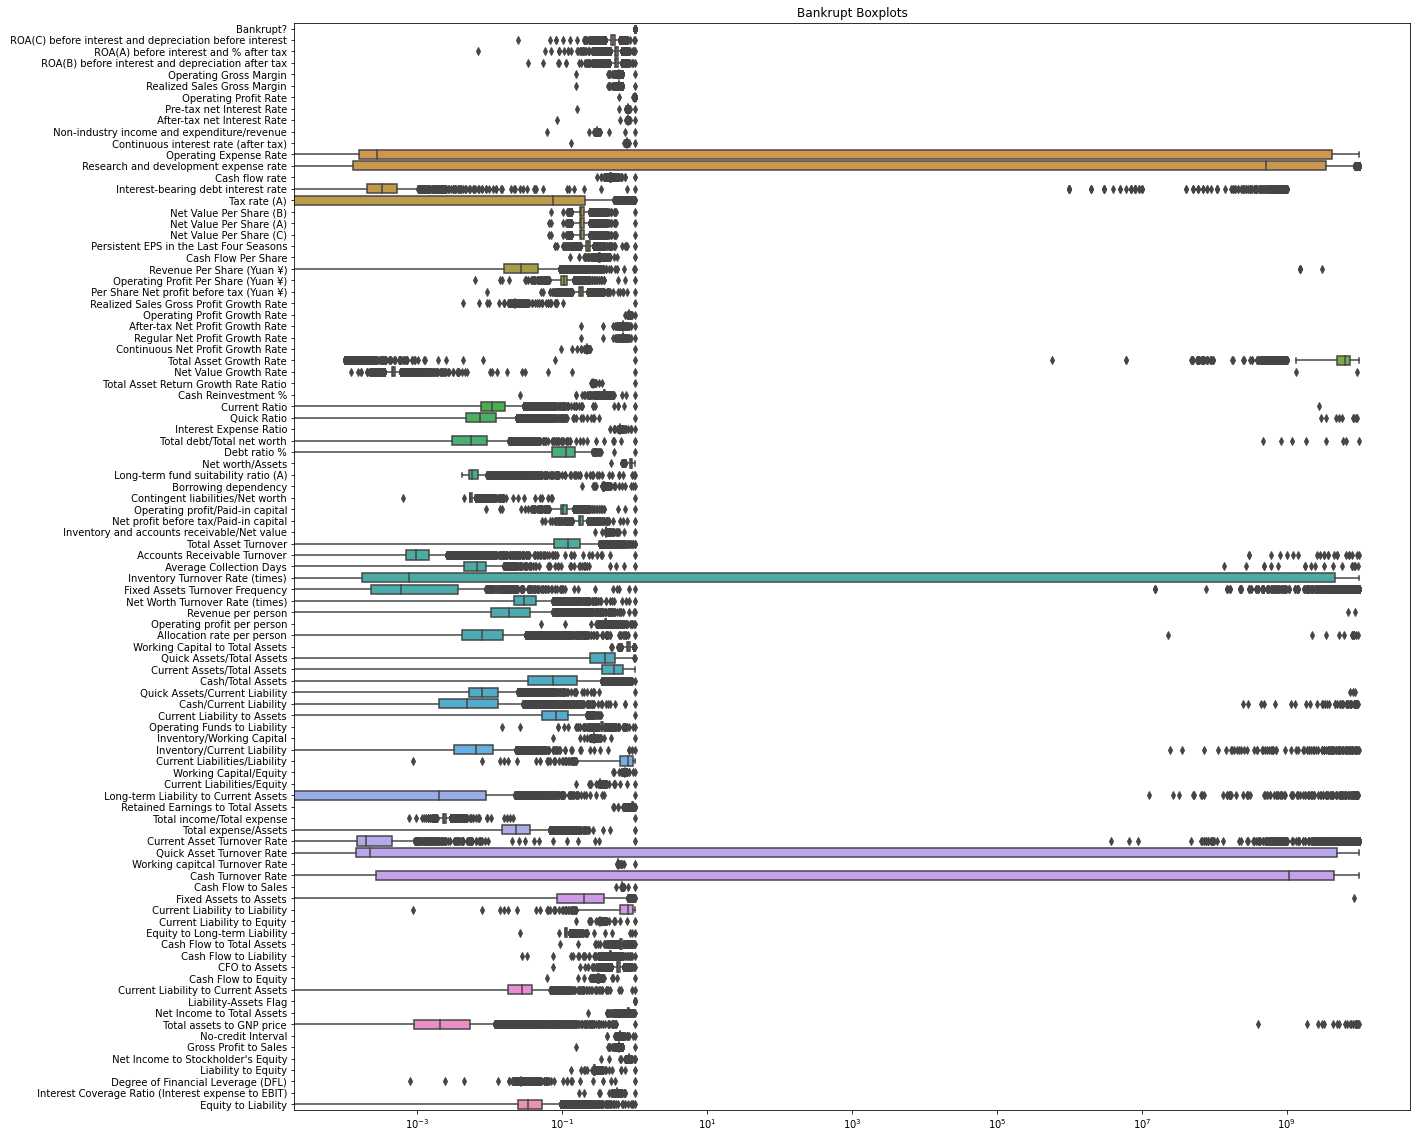

In [12]:
# Visualize outliers using box plot
fig,ax = plt.subplots(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bankrupt Boxplots')
ax.set(xscale="log")
plt.show()

In [13]:
#Identify the actual indexes of the outlying observations using Tukey’s box plot method
for col in df:
  print(str(col))
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  inner_fence = 1.5*iqr
  outer_fence = 3*iqr

  #inner fence lower and upper end
  inner_fence_le = q1-inner_fence
  inner_fence_ue = q3+inner_fence

  #outer fence lower and upper end
  outer_fence_le = q1-outer_fence
  outer_fence_ue = q3+outer_fence

  outliers = [x for x in df[col] if (x <= inner_fence_le) or (x >= inner_fence_ue) or x <= outer_fence_le or x >= outer_fence_ue]
  print(f"Number of outliers is {len(outliers)}")
  df_cleaned = df.drop(df[(df[str(col)] <= inner_fence_le) | (df[str(col)] >= inner_fence_ue)].index)


Bankrupt?
Number of outliers is 6819
 ROA(C) before interest and depreciation before interest
Number of outliers is 391
 ROA(A) before interest and % after tax
Number of outliers is 561
 ROA(B) before interest and depreciation after tax
Number of outliers is 432
 Operating Gross Margin
Number of outliers is 320
 Realized Sales Gross Margin
Number of outliers is 318
 Operating Profit Rate
Number of outliers is 716
 Pre-tax net Interest Rate
Number of outliers is 773
 After-tax net Interest Rate
Number of outliers is 867
 Non-industry income and expenditure/revenue
Number of outliers is 1094
 Continuous interest rate (after tax)
Number of outliers is 806
 Operating Expense Rate
Number of outliers is 0
 Research and development expense rate
Number of outliers is 182
 Cash flow rate
Number of outliers is 576
 Interest-bearing debt interest rate
Number of outliers is 396
 Tax rate (A)
Number of outliers is 120
 Net Value Per Share (B)
Number of outliers is 457
 Net Value Per Share (A)
Numbe

In [14]:
print(f'Shape {df_cleaned.shape}')

Shape (6270, 95)


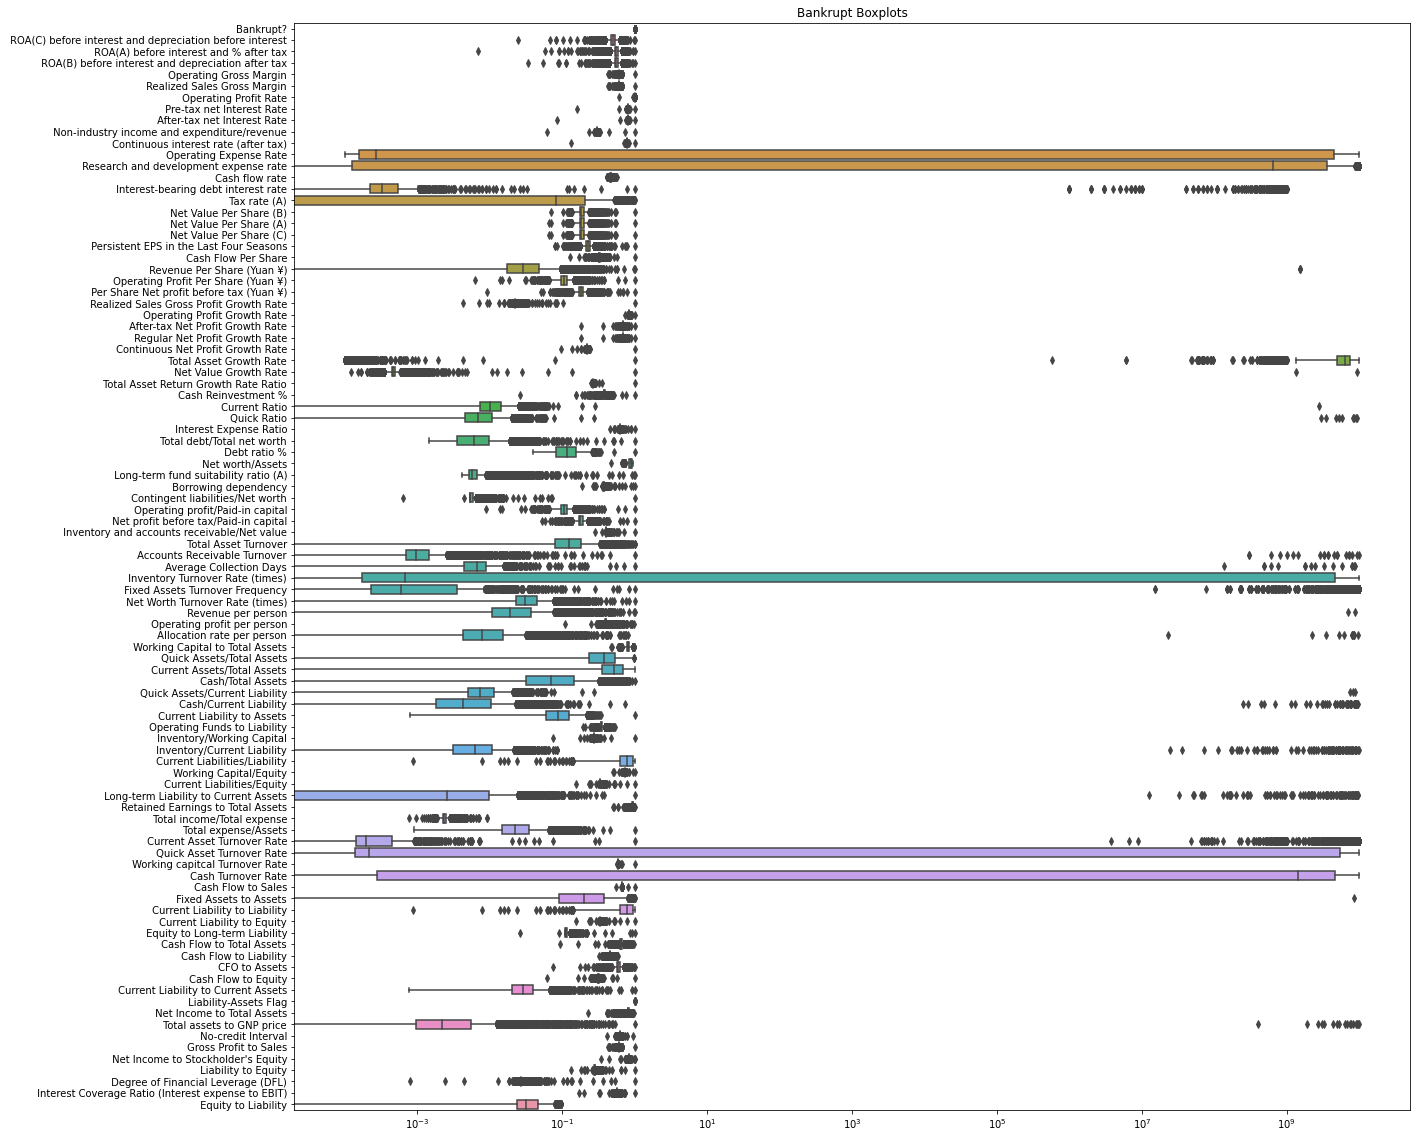

In [15]:
fig,ax = plt.subplots(figsize = (20,20))
ax =sns.boxplot(data = df_cleaned, orient="h")
ax.set_title('Bankrupt Boxplots')
ax.set(xscale="log")
plt.show()

# Feature Selection

Find the top correlating features

In [16]:
# listing the top correlated features
corr = df.corr()
top_cor_col = corr[["Bankrupt?"]].apply(abs).sort_values('Bankrupt?', ascending=False).iloc[1:11,:].index
list(top_cor_col)


[' Net Income to Total Assets',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Net worth/Assets',
 ' Debt ratio %',
 ' Persistent EPS in the Last Four Seasons',
 ' Retained Earnings to Total Assets',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)']

# Modeling

**Logistic Regression**

In [17]:
# set training set and testing set
X = df_cleaned.drop('Bankrupt?', axis=1)
y = df_cleaned['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

In [18]:
X_train_top_10 = X_train[top_cor_col]
X_test_top_10 = X_test[top_cor_col]
top_10_pipeline = Pipeline([('std', StandardScaler()),
             ('logistic_regression', LogisticRegression(random_state=4))])
top_10_cv = cross_validate(top_10_pipeline, 
                           X_train_top_10, y_train, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring=['precision', 'neg_log_loss'])

In [19]:
top_10_cv_score = cross_val_score(top_10_pipeline, 
                           X_train_top_10, y_train, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision')

In [20]:
top_10_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('std', StandardScaler()),
                ('logistic_regression', LogisticRegression(random_state=4))])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


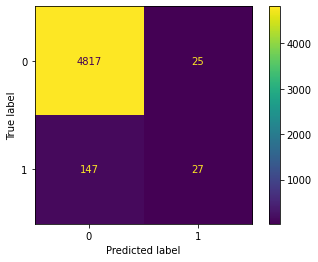

In [21]:
plot_confusion_matrix(top_10_pipeline, X_train_top_10, y_train);

In [22]:
print(classification_report(y_train, top_10_pipeline.predict(X_train_top_10)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4842
           1       0.52      0.16      0.24       174

    accuracy                           0.97      5016
   macro avg       0.74      0.58      0.61      5016
weighted avg       0.95      0.97      0.96      5016



In [23]:
recall_score_top_10 = recall_score(y_train, top_10_pipeline.predict(X_train_top_10))
recall_score_top_10

0.15517241379310345

In [24]:
precision_score_top_10 = precision_score(y_train, top_10_pipeline.predict(X_train_top_10))
precision_score_top_10

0.5192307692307693

We are unable to correctly predict many of the companies. This may be due to the imbalanced data set.

**Modeling with Oversampling and Undersampling**

We will use an oversampling method and undersampling method to rebalance the data.

In [25]:
stratified_kfold = StratifiedKFold(n_splits=5, 
                                   random_state=4, 
                                   shuffle=True)

In [26]:
over_pipeline = imbpipeline([('smote', SMOTE(random_state=4)),
             ('std', StandardScaler()),
             ('over', LogisticRegression(random_state=4))])
under_pipeline = imbpipeline([('undie', RandomUnderSampler(random_state=4)),
              ('std', StandardScaler()),
              ('under', LogisticRegression(random_state=4))])

In [27]:
over_param_grid = {'over__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

under_param_grid = {'under__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [28]:
over_grid_search = GridSearchCV(estimator=over_pipeline,
                                param_grid=over_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [29]:
under_grid_search = GridSearchCV(estimator=under_pipeline,
                                 param_grid=under_param_grid,
                                 scoring=['precision', 'neg_log_loss'],
                                 cv=stratified_kfold,
                                 n_jobs=-1,
                                 refit='precision')

In [30]:
over_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4)),
                                       ('std', StandardScaler()),
                                       ('over',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'over__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [31]:
over_grid_search.score(X_train_top_10, y_train)

0.18969849246231155

In [32]:
under_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('undie',
                                        RandomUnderSampler(random_state=4)),
                                       ('std', StandardScaler()),
                                       ('under',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'under__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [33]:
under_grid_search.score(X_train_top_10, y_train)

0.17445838084378562

In [34]:
over_grid_search.best_params_

{'over__C': 1000}

In [35]:
under_grid_search.best_params_

{'under__C': 10}

In [36]:
best_over_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('best_over_over', LogisticRegression(C=1000,
                                         random_state=4))]
best_under_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('best_under_under', LogisticRegression(C=10,
                                         random_state=4))]

In [37]:
best_over_pipeline = imbpipeline(best_over_steps)
best_under_pipeline = imbpipeline(best_under_steps)

In [38]:
best_over_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=4)), ('ss', StandardScaler()),
                ('best_over_over', LogisticRegression(C=1000, random_state=4))])

In [39]:
best_under_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=4)), ('ss', StandardScaler()),
                ('best_under_under', LogisticRegression(C=10, random_state=4))])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


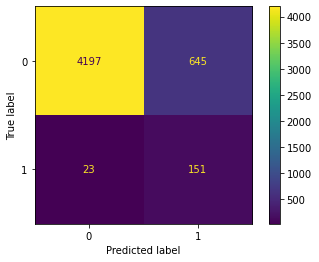

In [40]:
plot_confusion_matrix(best_over_pipeline, X_train_top_10, y_train);

In [43]:
recall_score_best_over = recall_score(y_train, best_over_pipeline.predict(X_train_top_10))
recall_score_best_over

0.867816091954023

In [44]:
precision_score_best_over = precision_score(y_train, best_over_pipeline.predict(X_train_top_10))
precision_score_best_over

0.18969849246231155

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


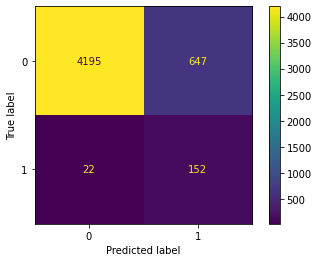

In [42]:
plot_confusion_matrix(best_under_pipeline, X_train_top_10, y_train);

In [45]:
precision_score_best_under = precision_score(y_train, best_under_pipeline.predict(X_train_top_10))
precision_score_best_under

0.1902377972465582

In [46]:
recall_score_best_under = recall_score(y_train, best_under_pipeline.predict(X_train_top_10))
recall_score_best_under

0.8735632183908046

We can see that our over and under sampling methods yielded higher precision scores than our basic model.